# Neural Style Transfer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

## Style transfer

The Neural Style Transfer is an algorithm that takes as input a content-image and a style-image and returns the content of the content-image as if it was ‘painted’ using the artistic style of the style-image.

For a style image I will use "The Jungle", 1942-43. <it>The Jungle</it> is a painting from the Cuban artist Wifredo Lam.

In [2]:
PATH = Path("/data2/yinterian/style-transfer/")

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(400, 383, 3)

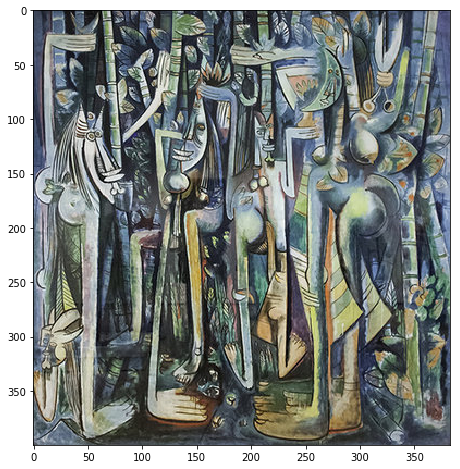

In [4]:
path = PATH/"lam.jpg"
im1 = read_image(path)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im1)
im1.shape

To get this image: <br>
`wget https://ka-perseus-images.s3.amazonaws.com/13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg
--2018-06-14 09:46:15--  https://ka-perseus-images.s3.amazonaws.com/13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg` <br>
`mv 13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg lam.jpg`

Here is my content image. This a picture of my son. You can use your favorite content image.

(300, 500, 3)

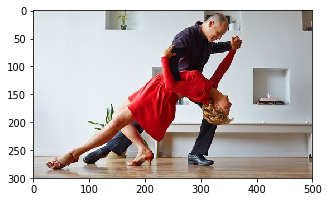

In [5]:
path2 = PATH/"dancing.jpg"
im2 = read_image(path2)
fig2 = plt.figure(figsize = (5,5)) 
plt.imshow(im2)
im2.shape

## Preprocessing
We need style and content images of the same size.

In [6]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

(300, 300, 3)

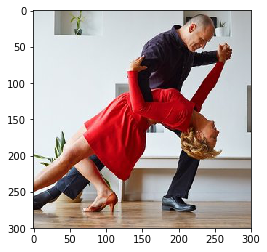

In [7]:
im2 = center_crop(im2)
im2 = cv2.resize(im2, (300, 300))
plt.imshow(im2)
im2.shape

In [8]:
im1 = center_crop(im1)
im1 = cv2.resize(im1, (300, 300))
im1.shape

(300, 300, 3)

In [9]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [10]:
im_style = transform_images(im1/255)
im_content = transform_images(im2/255)

In [11]:
im_style.shape

torch.Size([1, 3, 300, 300])

## Prepare vgg16

In [12]:
# get vgg16 model
vgg = models.vgg19(True).cuda().eval()

In [13]:
list(vgg.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace)
   (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (17): ReLU(inplace)
   (18): MaxPool2d(kernel_size=2, s

In [14]:
layers = list(vgg.children())[0]
m_vgg = nn.Sequential(*layers[:20]) # after conv4_1
# freezing parameters
for param in m_vgg.parameters():
    param.requires_grad = False

In [15]:
# indices for all Relus
block_relu = [i for i,o in enumerate(layers)
              if isinstance(o, nn.ReLU)]
block_relu

[1, 3, 6, 8, 11, 13, 15, 17, 20, 22, 24, 26, 29, 31, 33, 35]

In [16]:
# indices for all MaxPool2d
[i for i,o in enumerate(layers) if isinstance(o, nn.MaxPool2d)]

[4, 9, 18, 27, 36]

## Content optimization

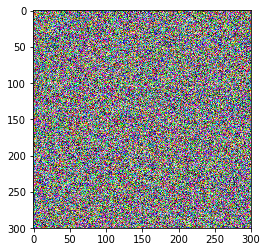

In [151]:
# start with a random image
opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
plt.imshow(opt_img)

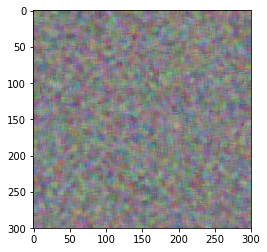

In [152]:
opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
plt.imshow(opt_img)

In [153]:
im_opt = transform_images(opt_img)
im_opt.shape

torch.Size([1, 3, 300, 300])

In [154]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
im_opt.requires_grad=True

In [155]:
# Making the image pixes the parameters of the model
optimizer = optim.LBFGS([im_opt], lr=0.01)

In [156]:
# the target here is the output of the content image
# after vgg16
targ_v = m_vgg(im_content)
targ_v.shape

torch.Size([1, 512, 37, 37])

In [157]:
F.mse_loss(m_vgg(im_opt), targ_v).item()

73.11103820800781

In [158]:
# for optim.LBFGS we have to define a closure function
def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            loss = F.mse_loss(m_vgg(im_opt), targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            print((F.mse_loss(m_vgg(im_opt), targ_v.detach())).item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [159]:
im_opt = train_image(optimizer, targ_v, im_opt, 1000)

55.46648406982422
4.616928577423096
1.8543612957000732
1.2003741264343262
0.9489452838897705
0.8261454701423645
0.7787909507751465
0.7681600451469421
0.6838410496711731
0.5917004346847534
0.5671876072883606
0.5639439225196838
0.5446959137916565
0.49344488978385925
0.47667649388313293
0.47446152567863464
0.4724467992782593
0.47184300422668457
0.44754067063331604
0.42330989241600037


In [160]:
x = im_opt.cpu().detach().numpy()

In [161]:
x = x[0]
x.shape

(3, 300, 300)

In [162]:
x = np.rollaxis(x,0,3)

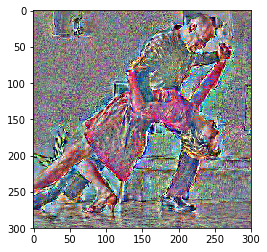

In [163]:
plt.imshow(x)

In [18]:
m_vgg._modules.keys()

odict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36'])

## Style Optimization

For style optimization we will be using conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1. These correspond to indices: `[1, 6, 11, 20, 29]`.

In [15]:
def get_input(lr=0.01):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.LBFGS([im_opt], lr=0.01)
    return im_opt, optimizer
im_opt, optimizer = get_input()

In [12]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['1', '6', '11', '20', '29'] 
        self.vgg = models.vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [56]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [57]:
opt_img, optimizer = get_input(lr=0.01)
vgg = VGGNet().cuda().eval()

In [58]:
im_style_f = vgg(im_style)

In [59]:
[o.shape for o in im_style_f]

[torch.Size([1, 64, 300, 300]),
 torch.Size([1, 128, 150, 150]),
 torch.Size([1, 256, 75, 75]),
 torch.Size([1, 512, 37, 37]),
 torch.Size([1, 512, 18, 18])]

In [60]:
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [61]:
def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [62]:
im_opt, optimizer = get_input(lr=0.1)

In [63]:
im_opt = train_style(optimizer, targ_g, im_opt, 1000)

0.06311345100402832
0.0630018413066864
0.06288879364728928
0.0627744048833847
0.06265833228826523
0.06254024058580399
0.06242026016116142
0.0037035392597317696
0.0004870586271863431
0.00018303947581443936
0.00014044334238860756
0.00012716880883090198
0.00012646251707337797
0.00012644409434869885
0.00012643101217690855
0.00012641998182516545
0.00012641023204196244
0.0001264013408217579
0.00012639313354156911
0.00012638540647458285


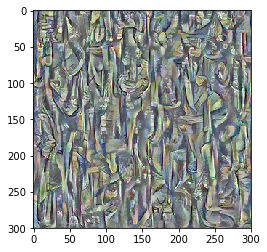

In [64]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

## Style transfer

In [76]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*5000
            loss += F.mse_loss(out[3], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*5000
            loss += F.mse_loss(out[3], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [77]:
im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

In [78]:
im_content_f = vgg(im_content)
targ_v = im_content_f[3].detach()
targ_v.shape

torch.Size([1, 512, 37, 37])

In [79]:
im_opt, optimizer = get_input(lr=0.01)

In [80]:
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 200)

7.386308670043945
1.0576688051223755
0.5935289859771729
0.48318755626678467


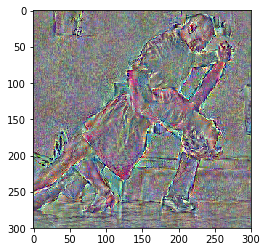

In [81]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

# References
The idea for the model in this notebook is based on notebook is based on this [pytorch tutorial](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/neural_style_transfer/main.py). I also looked at these other notebooks and papers:

* This [fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb) 
* This [paper](https://arxiv.org/pdf/1508.06576.pdf).
* This [block post](https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199)